# Learn Xception architecture from scratch with Pytorch

This is my first model Xception architecture in Pytorch.

The link of the paper is :

https://arxiv.org/pdf/1610.02357.pdf

So we get the following picture of the architecture :

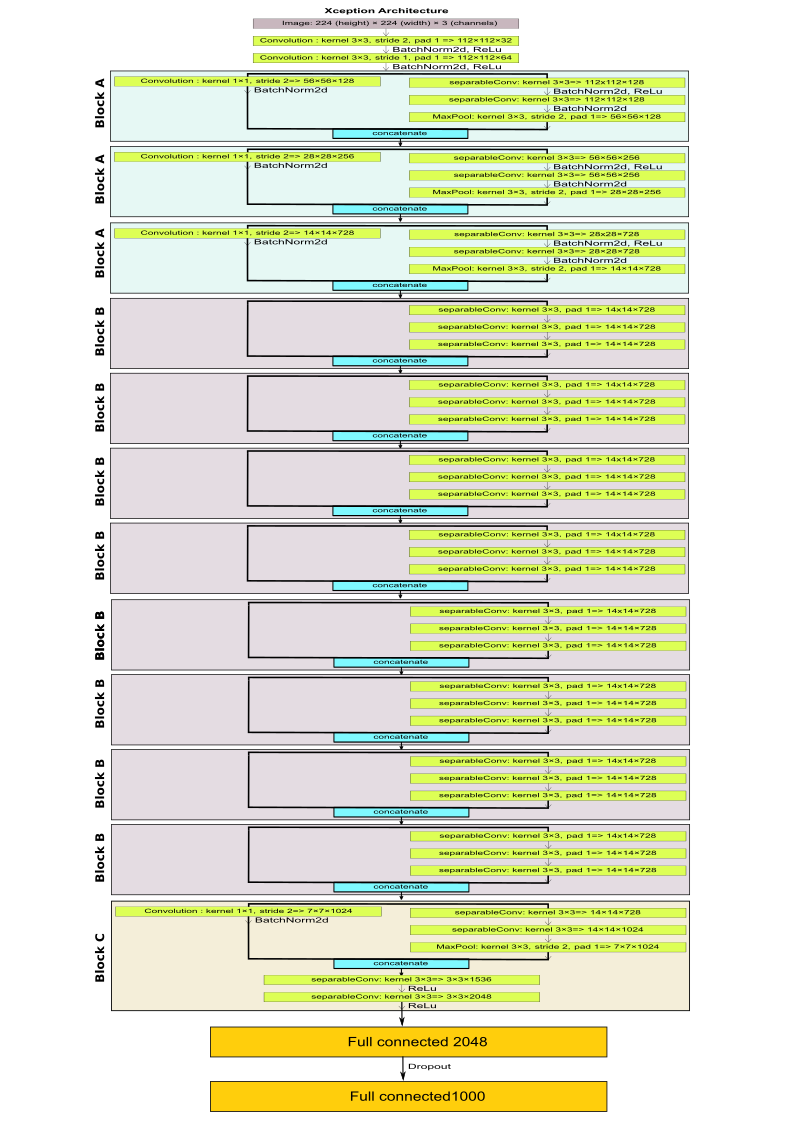

# With Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [2]:
class separableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_Size, activation, padding = 0):
        super(separableConv2D, self).__init__()

        self.depthwise = nn.Conv2d(in_channels = in_channels, out_channels = in_channels, kernel_size = kernel_Size, groups = in_channels, stride = (1,1), padding = padding)
        self.pointwise = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = (1,1))

        self.batchNormalization = nn.BatchNorm2d(num_features = out_channels)

        self.activation = nn.ReLU(inplace = True)
        self.act = activation
        
    def forward(self,x):
        
        out = self.depthwise(x)
        out = self.pointwise(out)
        out = self.batchNormalization(out)
        
        if self.act :
            out = self.activation(out)

        return out

In [3]:
class Conv_Block_A(nn.Module):
    def __init__(self, in_channels, num_kernels):
        super(Conv_Block_A, self).__init__()
        
        self.branch1 = nn.Conv2d(in_channels = in_channels, out_channels = num_kernels, kernel_size = (1,1), stride = (2,2))
        self.batchNorm1 = nn.BatchNorm2d(num_kernels)
        
        self.branch2 = nn.Sequential(
                                    separableConv2D(in_channels = in_channels, out_channels = num_kernels, kernel_Size = (3,3), padding = (1,1), activation = True) , 
                                    nn.BatchNorm2d(num_kernels),
                                                   
                                    separableConv2D(in_channels = num_kernels, out_channels = num_kernels, kernel_Size = (3,3), padding = (1,1), activation = False),
                                    nn.BatchNorm2d(num_kernels),
            
                                    nn.MaxPool2d(kernel_size = (3,3), stride = (2,2), padding = (1,1))
                                    ) 
        
    def forward(self , x):
 
        branch1 = self.branch1(x)
        #print('After branch1 : ', branch1.shape)
        branch1 = self.batchNorm1(branch1)
        
        branch2 = self.branch2(x)
        #print('After branch2 : ', branch2.shape)
        
        return torch.cat([branch1 , branch2])

In [4]:
class Conv_Block_B(nn.Module):
    def __init__(self,in_channels):
        super(Conv_Block_B , self).__init__()
        
        self.branch1 = nn.Sequential(
                                    separableConv2D(in_channels = in_channels, out_channels = in_channels, kernel_Size = (3,3), padding = (1,1), activation = True),                                    
                                    separableConv2D(in_channels = in_channels, out_channels = in_channels, kernel_Size = (3,3), padding = (1,1), activation = True),            
                                    separableConv2D(in_channels = in_channels, out_channels = in_channels, kernel_Size = (3,3), padding = (1,1), activation = False)           
                                    )       
    def forward(self , x):
        
        branch1 = self.branch1(x) 
        #print('After branch1 : ', branch1.shape)
        
        #print('After x : ', x.shape)

        out = torch.cat([branch1 , x])
        
        return out

In [5]:
class Conv_Block_C(nn.Module):
    def __init__(self):
        super(Conv_Block_C, self).__init__()

        self.branch1 = nn.Conv2d(in_channels = 728, out_channels = 1024, kernel_size = (1,1), stride = (2,2))
        self.batchNorm1 = nn.BatchNorm2d(1024)    
        
        self.branch2 = nn.Sequential(
                                    separableConv2D(in_channels = 728,out_channels = 728, kernel_Size = 3, padding = (1,1), activation = True) ,
                                    separableConv2D(in_channels = 728,out_channels = 1024, kernel_Size = 3, padding = (1,1), activation = False) ,
                                    nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)
                                    )
        
        self.branch3 = separableConv2D(in_channels = 2048 ,out_channels =  1536 , kernel_Size = 3  , activation = True)
        self.branch4 = separableConv2D(in_channels = 1536 ,out_channels =  2048 , kernel_Size = 3  , activation = True)
        
 
    def forward(self , x):
        
        branch1 = self.branch1(x)
        
        branch2 = self.branch2(x)

        out = torch.cat([branch1 , branch2], 1)

        out = self.branch3(out)
        out = self.branch4(out)

        return out

In [6]:
class Xception(nn.Module):
    def __init__(self):
        super(Xception , self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 32 , kernel_size = 3 , stride = 2, padding = 1)
        self.BatchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32 , out_channels = 64 , kernel_size = 3, padding = 1)
        self.BatchNorm2 = nn.BatchNorm2d(64)

        self.convBlock_A_1 = Conv_Block_A(64 , 128)
        self.convBlock_A_2 = Conv_Block_A(128 , 256)
        self.convBlock_A_3 = Conv_Block_A(256 , 728)
        
        self.convBlock_B = Conv_Block_B(728)
        
        self.convBlock_C = Conv_Block_C()
        
        self.fc1 = nn.Linear(in_features=2048, out_features= 2048)
        self.fc2 = nn.Linear(in_features=2048, out_features= 1000)
        
        self.Relu = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout(p = 0.5, inplace = False)
        
    def forward(self , x):
 
        out = self.conv1(x)
        out = self.BatchNorm1(out)
        out = self.Relu(out)
     
        out = self.conv2(out)
        out = self.BatchNorm2(out)
        out = self.Relu(out)

        out = self.convBlock_A_1(out)
        out = self.convBlock_A_2(out)
        out = self.convBlock_A_3(out)
        
        for _ in range (8):
            out = self.convBlock_B(out)
            
        out = self.convBlock_C(out)
        
        #out = F.avg_pool2d(out, out.size()[2:])
        # https://discuss.pytorch.org/t/global-average-pooling-in-pytorch/6721/19
        out = torch.mean(out.view(out.size(0), out.size(1), -1), dim = 2)
        
        out = self.fc1(out)
        out = self.dropout(out)
 
        out = self.fc2(out)
        
        return out

In [7]:
dev = torch.device("cpu") 

model_1 = Xception().to(dev)
print(summary(model_1,(3,224,224), device = 'cpu'))

C:\Users\wave\anaconda3\envs\ptf\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7          [-1, 128, 56, 56]           8,320
       BatchNorm2d-8          [-1, 128, 56, 56]             256
            Conv2d-9         [-1, 64, 112, 112]             640
           Conv2d-10        [-1, 128, 112, 112]           8,320
      BatchNorm2d-11        [-1, 128, 112, 112]             256
             ReLU-12        [-1, 128, 112, 112]               0
  separableConv2D-13        [-1, 128, 112, 112]               0
      BatchNorm2d-14        [-1, 128, 1

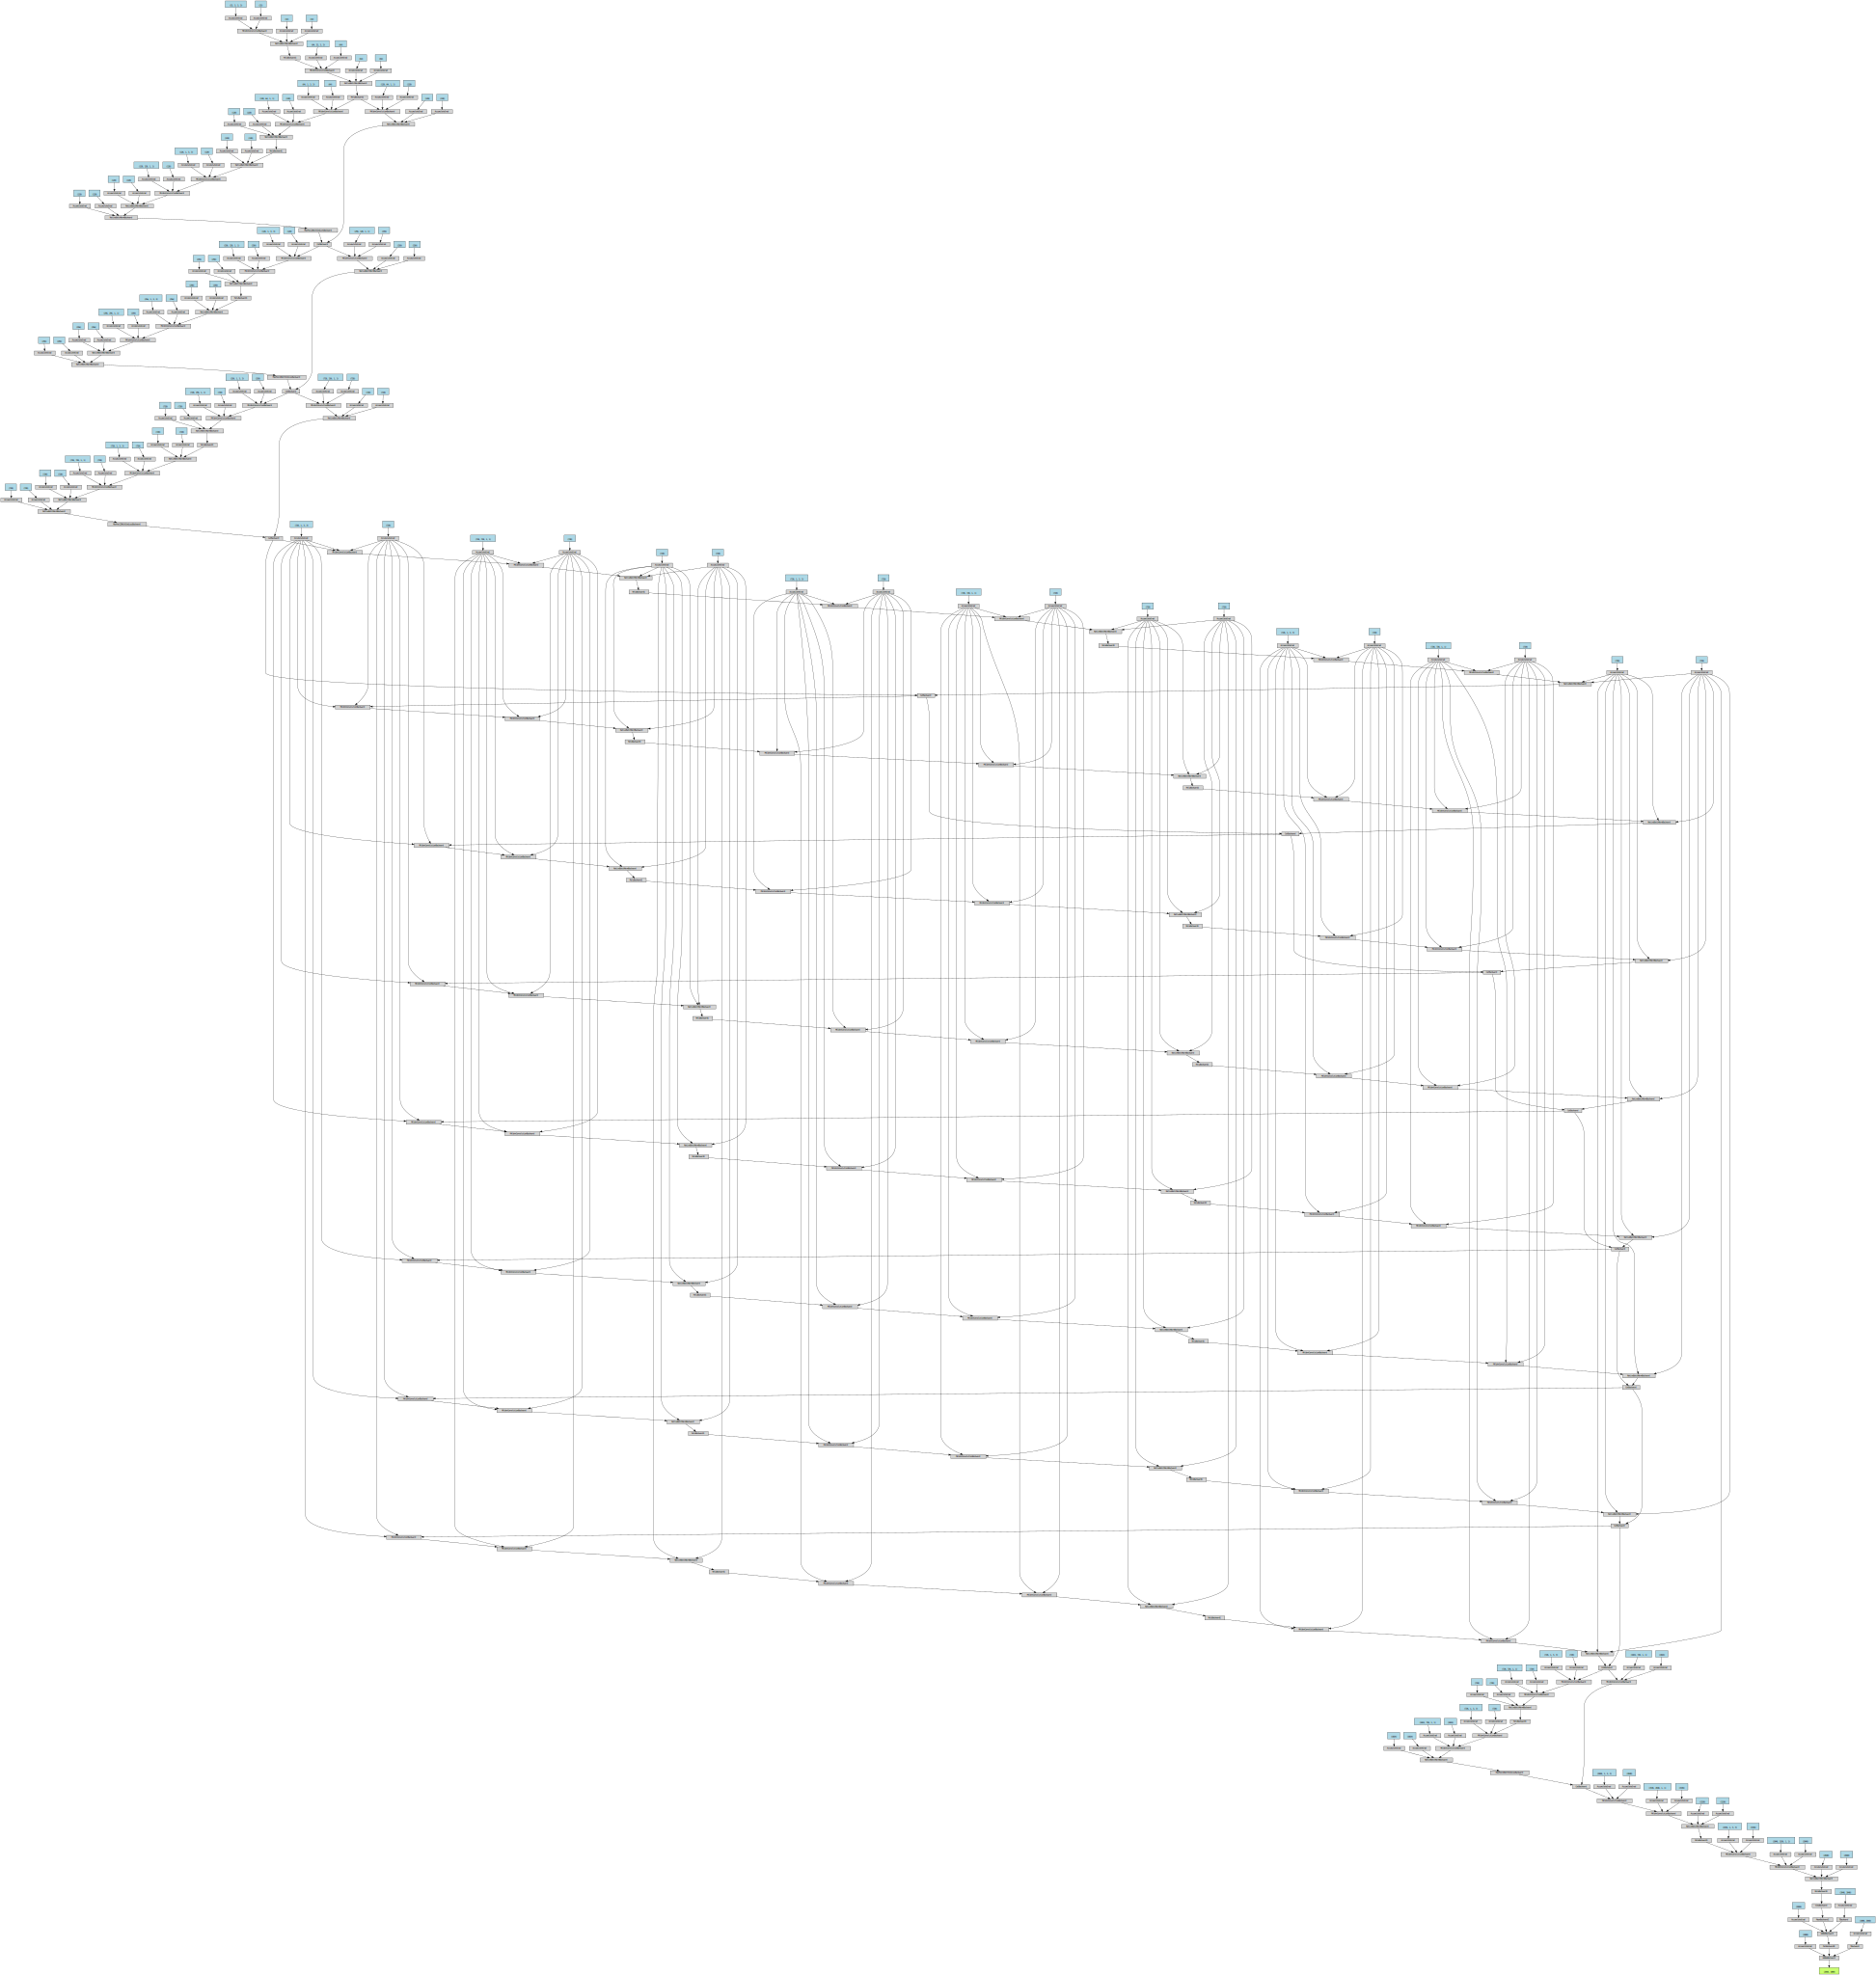

In [8]:
from torchviz import make_dot

x = torch.randn(1, 3, 224, 224)

model_1_cpu = Xception()
model_1_cpu_out = model_1_cpu(x)

#g = make_dot(out, params=None)
#g.view()
make_dot(model_1_cpu_out, params = None)

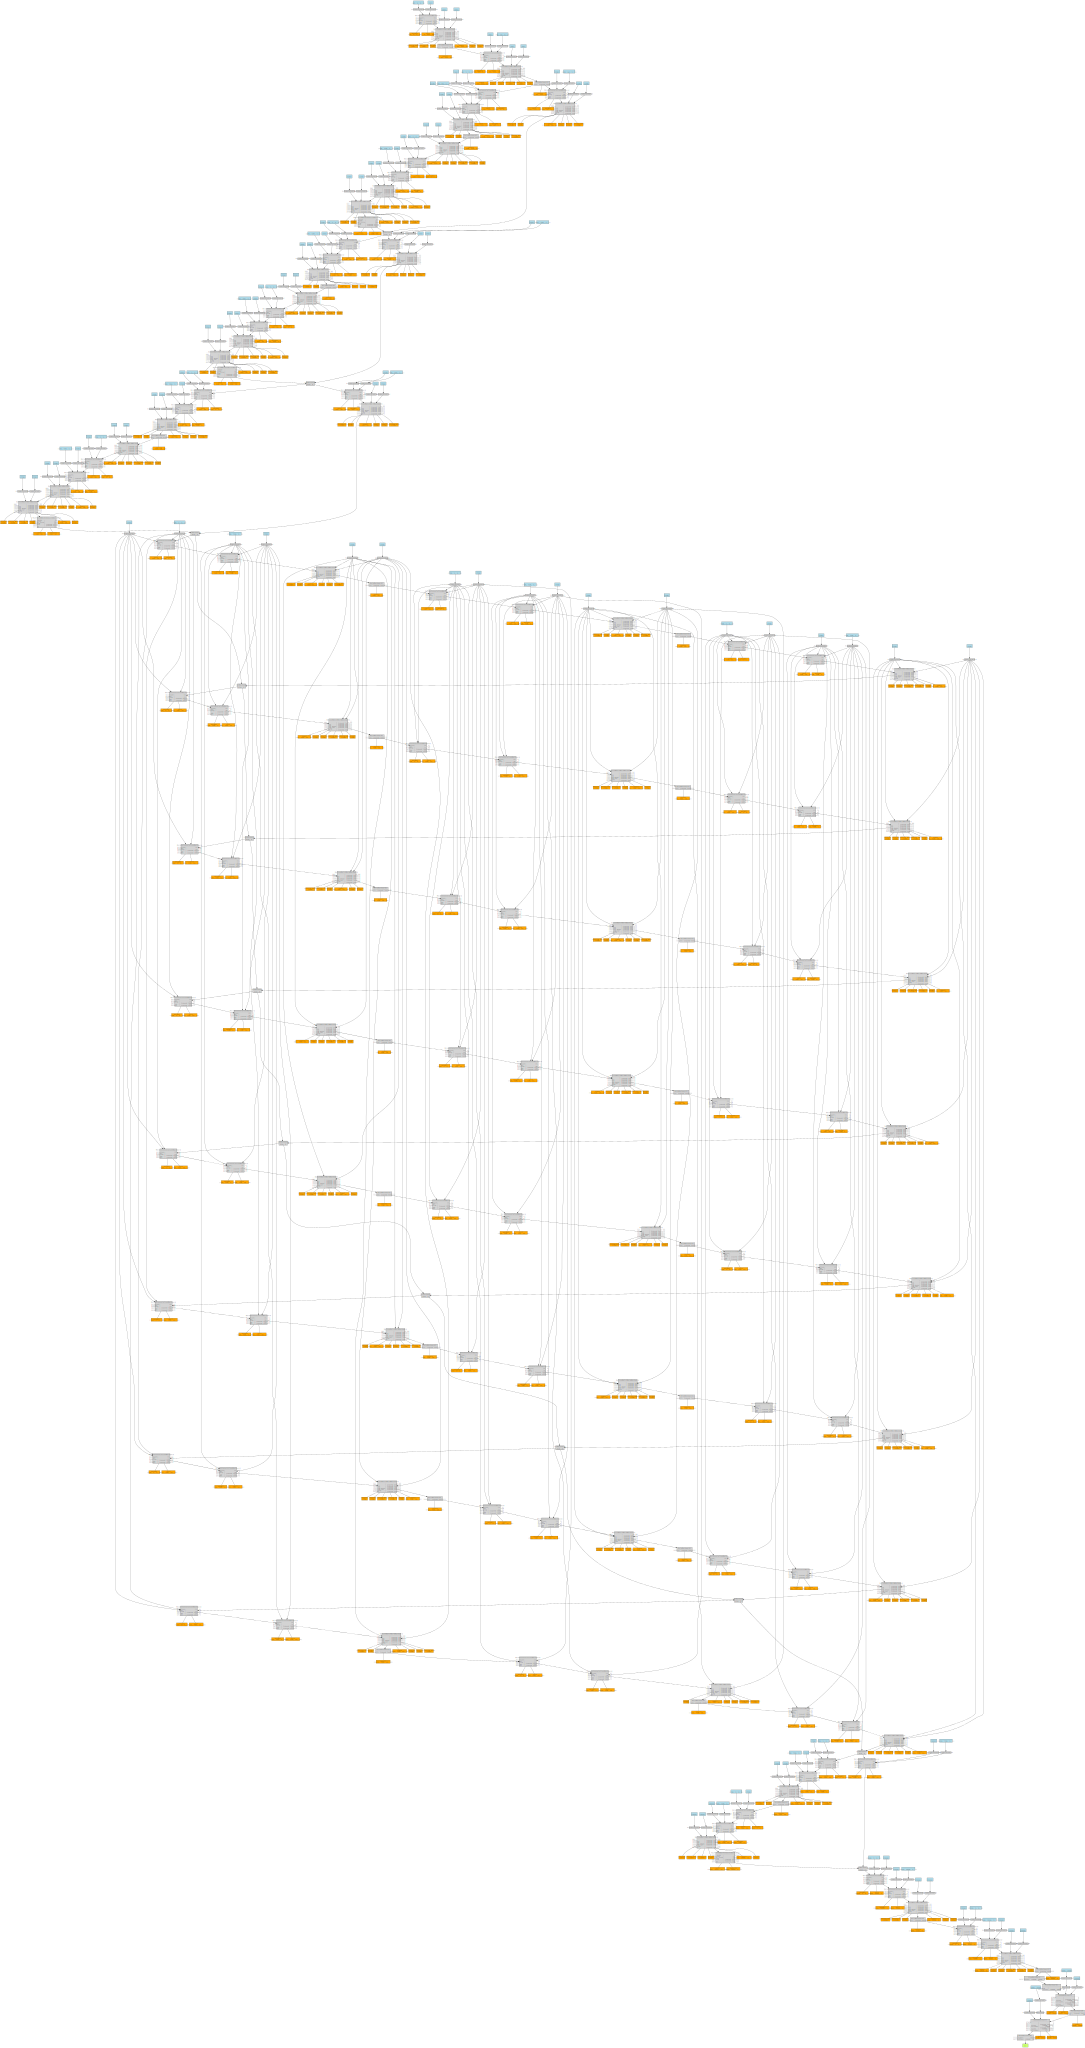

In [9]:
make_dot(model_1_cpu_out.mean(), params = None, show_attrs = True, show_saved = True)